In [2]:
import os
import sys
sys.path.append('/home/mehdi/github/LSSutils')
import fitsio as ft
from lssutils.utils import EnsembleWeights
from astropy.table import Table

In [21]:
nside = 256

target = 'LRG'
region = 'NBMZLS'
version = 'v0'

root_dir = '/home/mehdi/data/dr9v0.57.0/'

wsys_dir = '/home/mehdi/data/dr9v0.57.0/sv3nn_v1/regression/'
wsys_path = f'{wsys_dir}sv3nn_{target}_{region}_256/nn-weights.fits'

cats_dir = f'{root_dir}sv3_v1/'
cat_path = f'{cats_dir}sv3target_{target}_{region}.fits'

out_path = f'{cats_dir}sv3target_{target}_{region}.fits_MrWsys/wsys_f{version}.fits'
out_dir = os.path.dirname(out_path)

print(f'read raw weights from {wsys_path}')
if not os.path.exists(out_dir):
    print(f'create {out_dir}')
    os.makedirs(out_dir)

print(f'write output weights in {out_path}')


dcat = ft.read(cat_path, columns=['RA', 'DEC'])
ew = EnsembleWeights(wsys_path, 256)

w_ = ew(dcat['RA'], dcat['DEC'])

table = Table(data=[w_], names=['wsys'])
table.write(out_path, format='fits')

read raw weights from /home/mehdi/data/dr9v0.57.0/sv3nn_v1/regression/sv3nn_LRG_NBMZLS_256/nn-weights.fits
create /home/mehdi/data/dr9v0.57.0/sv3_v1/sv3target_LRG_NBMZLS.fits_MrWsys
write output weights in /home/mehdi/data/dr9v0.57.0/sv3_v1/sv3target_LRG_NBMZLS.fits_MrWsys/wsys_fv0.fits


In [10]:
tmpl_ = pd.read_hdf(f'/home/mehdi/data/templates/dr9/pixweight_dark_dr9m_nside256.h5')
cols = ['stardens', 'ebv', 'loghi',
         'psfdepth_g', 'psfdepth_r', 'psfdepth_z',
         'galdepth_g', 'galdepth_r', 'galdepth_z', 
         'psfsize_g', 'psfsize_r', 'psfsize_z', 
         'psfdepth_w1', 'psfdepth_w2']

tmpl = tmpl_[cols].values

In [13]:
nran = hpixsum(256, rcat['RA'], rcat['DEC'])*1.0

In [11]:
ngal_now = hpixsum(256, dcat['RA'], dcat['DEC'])*1.0
ngal_rf  = hpixsum(256, dcat['RA'], dcat['DEC'], weights=wrf)

In [12]:
from lssutils.stats.nnbar import MeanDensity

In [19]:
is_good = np.isfinite(tmpl).sum(axis=1) == 14

In [20]:
mask = (nran > 0)  & is_good

In [24]:
bins = np.linspace(*np.percentile(tmpl[mask, 0], [5, 95]), 9)
bins

array([ 305.01837158,  579.05834198,  853.09831238, 1127.13828278,
       1401.17825317, 1675.21822357, 1949.25819397, 2223.29816437,
       2497.33813477])

In [70]:
def run_meandensity(ngal, nran, mask, selection=None):
    nb = MeanDensity(ngal, nran, mask, tmpl[:, 0], selection=selection, binning='simple', bins=bins)
    nb.run()
    return nb.output

In [85]:
nbar = {}
nbar['No Weight'] = run_meandensity(ngal_now, nran, mask)
nbar['RF'] = run_meandensity(ngal_rf, nran, mask)

In [87]:
for i in range(20):
    
    nbar['NN-%d'%i] = run_meandensity(ngal_now, nran, mask, selection=wnn.fetch(i))
    print('.', end=' ')

. . . . . . . . . . . . . . . . . . . . 

In [91]:
def add_plot(ax, nb, werr=False, **kw):
    if werr:
        ax.errorbar(nb['bin_avg'], nb['nnbar'], yerr=nb['nnbar_err'], **kw)
    else:
        ax.plot(nb['bin_avg'], nb['nnbar'], **kw)

[Text(0, 0.5, 'Mean Density'), Text(0.5, 0, 'Star Density')]

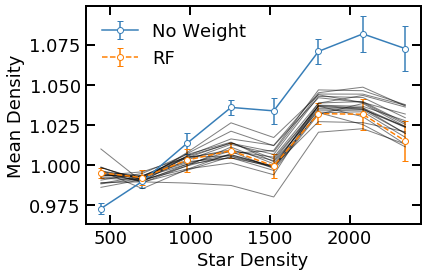

In [95]:
fig, ax = plt.subplots()


for name_, nbar_ in nbar.items():
    if 'NN' in name_:
        add_plot(ax, nbar_, werr=False, ls='-', lw=1, color='k', alpha=0.5)
    else:
        add_plot(ax, nbar_, werr=True, label=name_, capsize=3, marker='o', mfc='w')
    
ax.legend(frameon=False)
ax.set(xlabel='Star Density', ylabel='Mean Density')

In [2]:
class SV3Data:
    
    def __init__(self, target, region):
        
        self.nside = 256
        
        p = f'{root_dir}sv3_v1/'
        self.dcat = ft.read(f'{p}sv3target_{target}_{region}.fits', 
                            columns=['RA', 'DEC'])
        self.rcat = ft.read(f'{p}{region}_randoms-1-0x2.fits', 
                            columns=['RA', 'DEC'])
        self.wrf = ft.read(f'{p}sv3target_{target}_{region}.fits_EdWsys/wsys_v0.fits')['wsys']
        print(f'mean(wnn): {self.wrf.mean():.2f}, {self.wrf.min():.1f} < wrf < {self.wrf.max():.1f}')

        
        p = f'{root_dir}sv3nn_v1/regression/'
        sw = NNWeight(f'{p}sv3nn_{target}_{region}_256/nn-weights.fits', self.nside)
        self.mask_ = sw.mask
        wnn = sw(self.dcat['RA'], self.dcat['DEC'])        
        self.wnn = wnn / np.median(wnn)
        self.wnn = self.wnn.clip(0.5, 2.0)
        print(f'mean(wnn): {self.wnn.mean():.2f}, {self.wnn.min():.1f} < wnn < {self.wnn.max():.1f}')
        
        self.af = AnaFast()
        
        tmpl = pd.read_hdf(f'/home/mehdi/data/templates/dr9/pixweight_dark_dr9m_nside{self.nside}.h5')
        #self.cols = ['nstar', 'ebv', 'loghi']\
        #              +[f'{s}_{b}' for s in ['ccdskymag_mean', 'fwhm_mean', 'fwhm_min', 'fwhm_max', 'depth_total', 
        #                                'mjd_mean', 'mjd_min', 'mjd_max', 'airmass_mean', 'exptime_total']\
        #                      for b in ['g', 'r', 'z']]
        self.cols = ['lognstar', 'ebv', 'loghi',
                     'psfdepth_g', 'psfdepth_r', 'psfdepth_z',
                     'galdepth_g', 'galdepth_r', 'galdepth_z', 
                     'psfsize_g', 'psfsize_r', 'psfsize_z', 
                     'psfdepth_w1', 'psfdepth_w2']

        self.tmpl = tmpl[self.cols].values        
        
        
        
    def make_delta(self):

        nran = hpixsum(self.nside, self.rcat['RA'], self.rcat['DEC'])*1.0
        self.mask = (nran > 0)
        print(f'mask: {self.mask.sum()} pixels')
        self.mask &= (self.mask_)
        print(f'mask: {self.mask.sum()} pixels (with imaging)') 
        self.frac = nran / nran[self.mask].mean()
        
        self.ngal_now = hpixsum(self.nside, self.dcat['RA'], self.dcat['DEC'])*1.0
        self.ngal_rf  = hpixsum(self.nside, self.dcat['RA'], self.dcat['DEC'], weights=self.wrf)
        self.ngal_wnn = hpixsum(self.nside, self.dcat['RA'], self.dcat['DEC'], weights=self.wnn)
        
        self.delta_now = make_overdensity(self.ngal_now, self.frac, self.mask)
        self.delta_rf  = make_overdensity(self.ngal_rf,   self.frac, self.mask)
        self.delta_wnn = make_overdensity(self.ngal_wnn, self.frac, self.mask)   
        
    def make_cl(self):
        self.cl_now = self.af(self.delta_now, self.frac, self.mask)
        self.cl_rf = self.af(self.delta_rf, self.frac, self.mask)
        self.cl_nn = self.af(self.delta_wnn, self.frac, self.mask)        
        
    def make_nbar(self):
        self.nbar_now = get_meandensity(self.ngal_now, self.frac, self.mask, self.tmpl)
        self.nbar_rf  = get_meandensity(self.ngal_rf,  self.frac, self.mask, self.tmpl)
        self.nbar_nn  = get_meandensity(self.ngal_wnn, self.frac, self.mask, self.tmpl)
        
    def make_pcc(self):
        self.pcc_now = pcc(self.tmpl[self.mask], self.delta_now[self.mask], return_err=True)
        self.pcc_rf  = pcc(self.tmpl[self.mask], self.delta_rf[self.mask])
        self.pcc_nn  = pcc(self.tmpl[self.mask], self.delta_wnn[self.mask])


setup_color()

In [4]:
target = 'LRG'
region = 'NBMZLS'

print(f'target: {target}, region: {region}')

target_region = f'{target}-{region}'


t0 = time()
sv = SV3Data(target, region)
t1 = time()
print(f'Finished reading in {t1-t0:.1f} sec')

sv.make_delta()
t2 = time()
print(f'Finished deltas in {t2-t1:.1f} sec')


sv.make_cl()
t3 = time()
print(f'Finished Cell in {t3-t2:.1f} sec')


sv.make_nbar()
t4 = time()
print(f'Finished nbar in {t4-t3:.1f} sec')


target: LRG, region: NBMZLS
mean(wnn): 0.97, 0.0 < wrf < 1.5
mean(wnn): 0.99, 0.5 < wnn < 2.0
Finished reading in 9.6 sec
mask: 99290 pixels
mask: 97581 pixels (with imaging)
Finished deltas in 2.5 sec
Finished Cell in 1.1 sec
Finished nbar in 62.3 sec


[None,
 (2e-08, 0.008),
 Text(0, 0.5, 'C$_{\\ell}$'),
 None,
 Text(0.5, 0, '$\\ell$')]

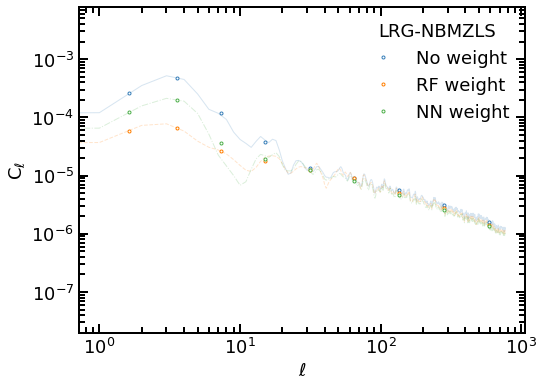

In [5]:

# C_ell
methods = ['No weight', 'RF weight', 'NN weight']
cls = [sv.cl_now, sv.cl_rf, sv.cl_nn]

fg, ax = plt.subplots(figsize=(8, 6))
for n_i, cl_i in zip(methods, cls ):

    lb, clb = histogram_cell(cl_i['cl'], bins=np.logspace(0, np.log10(770), 10))
    
    l_, = ax.plot(cl_i['cl'], lw=1, zorder=-1, alpha=0.2)
    ax.plot(lb, clb, marker='.', mfc='w', ls='None', color=l_.get_color(), label=n_i)
    
ax.legend(title=target_region, frameon=False)
ax.set(xscale='log', yscale='log', ylim=(2.0e-8, 8.0e-3), 
       xlabel=r'$\ell$', ylabel=r'C$_{\ell}$')

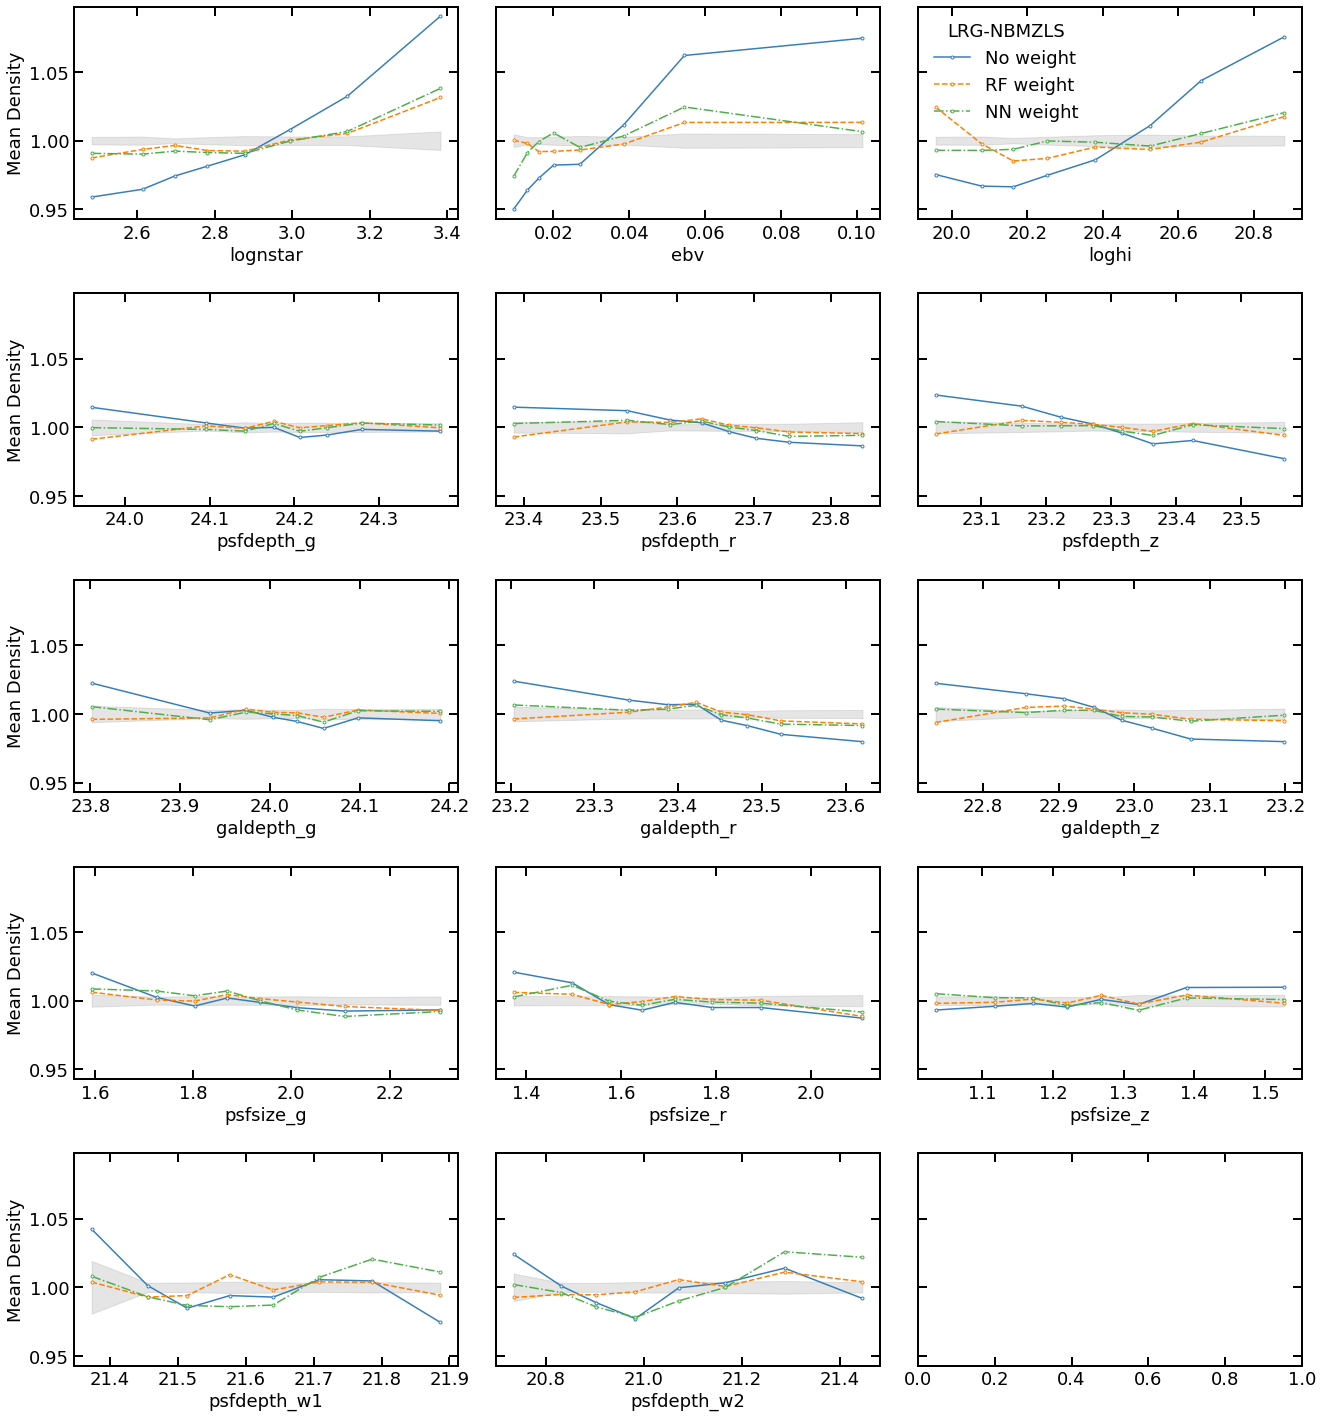

In [6]:
# Nbar
fig, ax = plt.subplots(ncols=3, nrows=5, figsize=(22, 25), sharey=True)
fig.subplots_adjust(hspace=0.35, wspace=0.1)
ax = ax.flatten()

nbars = [sv.nbar_now, sv.nbar_rf, sv.nbar_nn]
for name_i, nbar_i in zip(methods, nbars):    
    for j, nbar_ij in enumerate(nbar_i):
        ax[j].plot(nbar_ij['bin_avg'], nbar_ij['nnbar'], marker='.', mfc='w', label=name_i)        
        if name_i == 'No weight':
            ax[j].fill_between(nbar_ij['bin_avg'], 1-nbar_ij['nnbar_err'], 1+nbar_ij['nnbar_err'],
                              color='grey', alpha=0.2, zorder=-1)                          
ax[2].legend(title=target_region, frameon=False)
for j, colj in enumerate(sv.cols):
    ax[j].set_xlabel(colj)
    if j%3==0:
        ax[j].set_ylabel('Mean Density')   